## Requirements

### Web-Scraping
#### 1. Take the base wg-gesucht URL and scrape the shared flats listed on the website
#### 2. most important data points are price, room size and number of flat mates

### Data Analyis
#### 1. Correlation analysis of room price and room size. Hypothesis: positive correlation
#### 2. Correlation analysis of room price and number of flat mates. Hypothesis: negative correlation

### Import all neccessary libraries

In [90]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt


### Set base wg-gesucht url
### Add string interpolation to allow easy iteration through listing pages

In [80]:
pageNumber = 1
URL = f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{pageNumber}.html?pagination=1&pu='


### Iterate through listing pages and scrape the required data points
### Place scraped data into a dataframe/dictionary

In [81]:
pages = range(5)
df = pd.read_html(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.1.html?pagination=1&pu=')[0]

#for i, page in enumerate(pages):
#   df.append(pd.read_html(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{i}.html?pagination=1&pu=')[0])


In [82]:
#df.head()
rentPrice = df.iloc[:,3].tolist()
roomSize = df.iloc[:,4].tolist()
rentPrice = rentPrice[0: len(rentPrice) -1 ]
roomSize = roomSize[0: len(roomSize) -1 ]

for i, el  in enumerate(rentPrice):
    rentPrice[i] = int(el[0 : len(el) - 1])

for i, el in enumerate(roomSize):
    roomSize[i] = int(el[0 : len(el) - 2])

print(rentPrice)
print(roomSize)

[350, 370, 500, 320, 460, 190, 525, 450, 610, 565, 390, 650, 320, 450, 500, 500, 385, 400, 450, 661]
[18, 20, 16, 13, 19, 14, 20, 25, 20, 25, 16, 22, 16, 14, 25, 18, 13, 12, 23, 24]


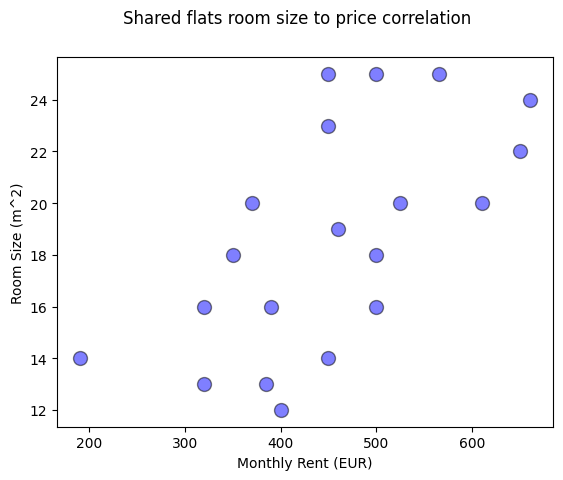

PearsonRResult(statistic=0.6269056324474553, pvalue=0.003094895395299458)

In [97]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Shared flats room size to price correlation")
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Room Size (m^2)')
plt.scatter(rentPrice, roomSize, s=100, c='blue',edgecolors='black', linewidths=1, alpha=0.5)
plt.show()

scipy.stats.pearsonr(rentPrice, roomSize)
